<a href="https://colab.research.google.com/github/YuruHuang/deep-learning-menu-healthiness/blob/main/04_Additional_Features_Price_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will

* Add new features (i.e., median price, average reviews) to see if the model performance can improve on the validation set - and yes it can!

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
justeat_menu = pd.read_csv('JustEat_extracted_211021.csv')
justeat_menu.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,n_reviews,average_review,item_price_mean,item_price_median,n_items,url,cuisine,address,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,review
0,80603,0,5,2,11,1,0,5,Pasha Kebabs & Pizzas,View 551 reviews,5.06 stars out of 6.,6.037634,7.000,93,URL,"Kebab,Pizza,Halal","25 Windmill Brae, Aberdeen, AB11 6HU",AB11 6HU,AB11,5,11,2,5.504342,1,551.0
1,71703,7,10,2,14,0,0,4,Paco's Tacos,View 2314 reviews,4.65 stars out of 6.,5.431358,4.450,162,URL,"Mexican,American","42-44 Market Street, Aberdeenshire, AB11 5PL",AB11 5PL,AB11,4,14,2,5.010865,0,2314.0
2,6885,0,16,12,1,0,0,2,Dil Se,View 1392 reviews,5.19 stars out of 6.,7.473418,8.225,158,URL,"Indian,Curry","Unit 8, The Green Berrymuir Road, Portlethen, ...",AB12 4UN,AB12,2,1,12,9.355489,4,1392.0
3,122605,5,10,6,44,0,0,1,Mannofield Pizza Grill and Kebab,View 386 reviews,5.16 stars out of 6.,8.069737,7.700,152,URL,"Pizza,Kebab","483a Great Western Road, Aberdeen, AB10 6NN",AB10 6NN,AB10,1,15,6,5.642945,1,386.0
4,44832,0,16,2,1,0,0,2,Lasan Healthy Indian Brasserie,View 595 reviews,5.04 stars out of 6.,6.877143,4.500,105,URL,"Indian,Healthy","Unit 2 Westhill Drive, Westhill, Aberdeenshire...",AB32 6FS,AB32,2,1,2,8.357649,3,595.0


In [2]:
ratings = pd.read_csv('ratings.csv')
ratings.head()
justeat_menu['hyginene'] = ratings.iloc[:,1]
# focus on England only: restaurants with hyginene ratings
justeat_hr = justeat_menu[justeat_menu['hyginene'].notnull()]
justeat_eng = justeat_hr[justeat_hr['hyginene'].str.contains('0|1|2|3|4|5')]
justeat_eng['hg_rating'] = justeat_eng.hyginene.astype("float64")
justeat_eng['rest_name'] = justeat_eng.rest_name.astype("string")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
justeat_eng['average_review_n']=justeat_eng.average_review.str.findall("\d+\.\d+").str[0].astype('float64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
# delete the records with NAs 
justeat_eng_na = justeat_eng.dropna()
justeat_eng_na.shape

(40316, 28)

In [5]:
# Train test split 
# Use train_test_split to split training data into training and test sets
train_data_all, test_data_all, train_label_all, test_label_all = train_test_split(justeat_eng_na[["item_price_median",'n_items','review','average_review_n','rest_name']],
                                                                  justeat_eng_na['predict'],
                                                                  test_size=0.1, # dedicate 10% of samples to test set
                                                                  random_state=42) # random state for repr

In [6]:
# Train validation Split 
X_train_hr_all, X_val_hr_all, y_train_hr_all, y_val_hr_all = train_test_split(train_data_all,train_label_all,test_size=0.1, random_state=42)

In [7]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

# set up character level tokenization
max_length_char = 25 # max length our sequences will be (e.g. how many characters from the restaurant name does our model see?)
max_char_length = 50

def char_split(input_data):
  return(tf.strings.unicode_split(input_data,'UTF-8'))

char_vectorizer = TextVectorization(max_tokens = max_char_length, 
                                    output_mode="int",
                                    split = char_split,
                                    standardize ="lower_and_strip_punctuation",
                                    output_sequence_length=max_length_char)

In [8]:
char_vectorizer.adapt(X_train_hr_all['rest_name'])

X_train_hr_name_char_all = char_vectorizer(tf.convert_to_tensor(X_train_hr_all['rest_name'].values))
print(X_train_hr_name_char_all.shape)

X_val_hr_name_char_all = char_vectorizer(tf.convert_to_tensor(X_val_hr_all['rest_name'].values))
print(X_val_hr_name_char_all.shape)

(32655, 25)
(3629, 25)


In [9]:
X_numeric_train_all = X_train_hr_all[["item_price_median",'n_items','review','average_review_n']].values 
X_numeric_val_all = X_val_hr_all[["item_price_median",'n_items','review','average_review_n']].values 

In [ ]:
X_numeric_train_all

array([[  4.5 , 142.  , 166.  ,   4.73],
       [  2.25,  33.  ,  13.  ,   5.49],
       [  5.  , 113.  , 585.  ,   5.15],
       ...,
       [  3.49,  57.  ,   9.  ,   4.33],
       [  7.45, 130.  , 931.  ,   5.21],
       [  4.6 , 124.  , 946.  ,   4.82]])

In [10]:
from tensorflow.keras.layers import Normalization
import numpy as np

layer = tf.keras.layers.Normalization(axis=1)
layer.adapt(X_numeric_train_all)
X_numeric_input_train = layer(X_numeric_train_all)
X_numeric_input_val = layer(X_numeric_val_all)

# Add new features

In [11]:
from tensorflow.keras import layers

nlp_input = tf.keras.Input(shape=(25,), name='nlp_input')
#nlp_token = word_vectorizer(nlp_input)
numeric_input = tf.keras.Input(shape=(4,), name='numeric_input')
#hygiene_out = layers.Dense(64, activation = 'relu')(hygiene_input)
#numeric_output = layers.Dense(64, activation='relu')(numeric_input)
emb = layers.Embedding(output_dim=64, input_dim=max_char_length, input_length=max_length_char)(nlp_input)
nlp_out = layers.GRU(64)(emb)
x = tf.concat([nlp_out, numeric_input],1)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)
model_10 = tf.keras.Model(inputs=[nlp_input , numeric_input], outputs=[x])

In [12]:
model_10.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

In [13]:
X_train_hr_all[["item_price_median",'n_items','review','average_review_n']]

,item_price_median,n_items,review,average_review_n
6894,4.50,142,166.0,4.73
7283,2.25,33,13.0,5.49
9417,5.00,113,585.0,5.15
43865,4.99,72,85.0,4.22
27494,4.19,43,297.0,3.94
...,...,...,...,...
42489,6.10,220,997.0,5.33
35420,7.50,89,55.0,4.87
46543,3.49,57,9.0,4.33
11413,7.45,130,931.0,5.21


In [14]:
model_10_history = model_10.fit([X_train_hr_name_char_all,X_numeric_input_train],y_train_hr_all, epochs=25,
                                validation_data = ([X_val_hr_name_char_all,X_numeric_input_val], y_val_hr_all))

Epoch 1/25
1021/1021 [==============================] - 20s 12ms/step - loss: 1.1194 - val_loss: 0.9423
Epoch 2/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.9496 - val_loss: 0.9353
Epoch 3/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.9158 - val_loss: 0.8948
Epoch 4/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.8901 - val_loss: 0.8813
Epoch 5/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.8667 - val_loss: 0.8454
Epoch 6/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.8512 - val_loss: 0.8355
Epoch 7/25
1021/1021 [==============================] - 11s 11ms/step - loss: 0.8314 - val_loss: 0.8270
Epoch 8/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.8106 - val_loss: 0.8170
Epoch 9/25
1021/1021 [==============================] - 10s 10ms/step - loss: 0.7900 - val_loss: 0.8188
Epoch 10/25
1021/1021 [==============================] - 10s 10m

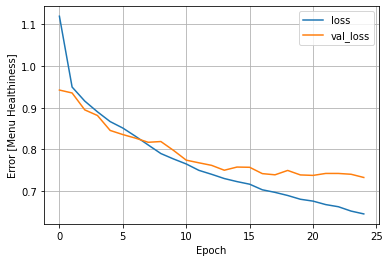

In [15]:
# plot the loss 
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Menu Healthiness]')
  plt.legend()
  plt.grid(True)

plot_loss(model_10_history)

# With only restaurant name and food hyginene, character level

Normalize the data before feeding into the neural networks (Model 8, but normalize the hygiene rating first)

In [ ]:
# Train test split 

# Use train_test_split to split training data into training and test sets
train_data, test_data, train_label, test_label = train_test_split(justeat_eng[["rest_name",'hg_rating']],
                                                                            justeat_eng["predict"],
                                                                            test_size=0.1, # dedicate 10% of samples to test set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
# Train validation Split 
X_train_hr, X_val_hr, y_train_hr, y_val_hr = train_test_split(train_data,train_label,test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

# set up character level tokenization
max_length_char = 25 # max length our sequences will be (e.g. how many characters from the restaurant name does our model see?)
max_char_length = 50

def char_split(input_data):
  return(tf.strings.unicode_split(input_data,'UTF-8'))

char_vectorizer = TextVectorization(max_tokens = max_char_length, 
                                    output_mode="int",
                                    split = char_split,
                                    standardize ="lower_and_strip_punctuation",
                                    output_sequence_length=max_length_char)

In [ ]:
char_vectorizer.adapt(X_train_hr['rest_name'])

X_train_hr_name_char = char_vectorizer(tf.convert_to_tensor(X_train_hr['rest_name'].values))
print(X_train_hr_name_char.shape)

X_val_hr_name_char = char_vectorizer(tf.convert_to_tensor(X_val_hr['rest_name'].values))
print(X_val_hr_name_char.shape)

(34634, 25)
(3849, 25)


In [ ]:
#import tensorflow as tf
#from tensorflow.keras import layers
nlp_input = tf.keras.Input(shape=(25,), name='nlp_input')
#nlp_token = word_vectorizer(nlp_input)
hygiene_input = tf.keras.Input(shape=(1,), name='hygiene_input')
#hygiene_out = layers.Dense(64, activation = 'relu')(hygiene_input)
emb = layers.Embedding(output_dim=64, input_dim=max_char_length, input_length=max_length_char)(nlp_input)
nlp_out = layers.GRU(64)(emb)
x = tf.concat([nlp_out, hygiene_input],1)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(1)(x)
model_8 = tf.keras.Model(inputs=[nlp_input , hygiene_input], outputs=[x])

In [ ]:
from tensorflow.keras.layers import Normalization
import numpy as np

layer_hr = tf.keras.layers.Normalization(axis=None)
layer_hr.adapt(X_train_hr['hg_rating'].values)
X_numeric_input_train_hr = layer_hr(X_train_hr['hg_rating'].values)
X_numeric_input_val_hr = layer_hr(X_val_hr['hg_rating'].values)

In [ ]:
model_8.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam())

model_8.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 25)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 25, 64)       3200        ['nlp_input[0][0]']              
                                                                                                  
 gru_4 (GRU)                    (None, 64)           24960       ['embedding_4[0][0]']            
                                                                                                  
 hygiene_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                            

In [ ]:
model_8_history = model_8.fit([X_train_hr_name_char,X_numeric_input_train_hr], y_train_hr, epochs=30,
                              validation_data = ([X_val_hr_name_char,X_numeric_input_val_hr], y_val_hr))

Epoch 1/30
1083/1083 [==============================] - 13s 10ms/step - loss: 0.8356 - val_loss: 0.8655
Epoch 2/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.8212 - val_loss: 0.8310
Epoch 3/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.8106 - val_loss: 0.8307
Epoch 4/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7985 - val_loss: 0.8275
Epoch 5/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7904 - val_loss: 0.8181
Epoch 6/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7838 - val_loss: 0.8102
Epoch 7/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7754 - val_loss: 0.8093
Epoch 8/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7666 - val_loss: 0.8042
Epoch 9/30
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7572 - val_loss: 0.7978
Epoch 10/30
1083/1083 [==============================] - 11s 10m

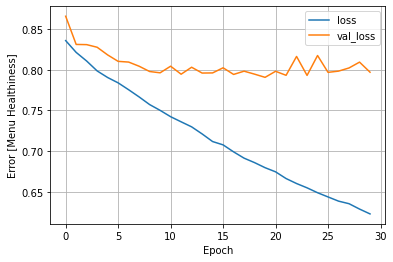

In [ ]:
plot_loss(model_8_history)